In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import dimod
import networkx as nx
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from dwave.system import DWaveSampler

In [7]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU DW_2000Q_6 was selected.


In [14]:
chain=[4,0,7,3,5,1,6,2,130,133,129,134,131,132,128,135,143,136,140,139,142,137,141,138,10,14,9,13,11,15,8,12,4]
#the length of "chain" is 32+1 because the first qubit (4) is repeated (PBC)
#print("Chain length is {}.".format(len(chain)))

#write the chain as tuples
chain_tups=[]
for i in range(len(chain)-1):
    q0=chain[i]
    q1=chain[i+1]
    chain_tups.append((q0,q1))

#define a function to reverse tuple
def Reverse(tup):
    return (tup[1],tup[0])

#check each tuple as to wether they are active in the chain
for tup in chain_tups:
    if (tup not in sampler.edgelist and Reverse(tup) not in sampler.edgelist):
        print(tup)

#finalize the coupler dictionary
chain_couplers={}
for tup in chain_tups:
    chain_couplers.update({tup:jval})

#check qubits
chain_qubs=[]
for tup in chain_tups:
    chain_qubs.append(tup[0])
    chain_qubs.append(tup[1])
chain_qubs=list(set(chain_qubs))
print("Real chain length is {} qubits.".format(len(chain_qubs)))

for i in range(len(chain_qubs)):
    q=chain_qubs[i]
    if q not in sampler.nodelist:
        print(q)

Real chain length is 32 qubits.


info on the sampler properties

In [16]:
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))

Maximum anneal-schedule points: 12
Annealing time range: [1.0, 2000.0]
Maximum slope allowed on this solver is 1.00.


# doing the run itself

note: parameters for the IBM-spectroscopy paper

J=1, h=0.3, g=0.25, t=30, dt=0.4

Time steps = 75
Circuits = 76

Shots = 8192

For the D-Wave machine, we have that at s=0.357, A(s)/B(s) = g/J = 0.25.

In [ ]:
#set vals
hval=-0.1
jval=-2.0
sval=0.353
pausetime = 15

In [59]:
def run_specific_pause(hval, jval, sval, pausetime, num_reads):

    #set initial state (+1)
    initial={}
    for q in chain_qubs:
        initial.update({int(q):1.0})
        
    #set hs
    hdict={}
    for q in chain_qubs:
        hdict.update({q:hval})
        
    #reverse anneal schedule (change as needed. but, must start with [0,1] and end at [tf,1])
    rev_sch=[[0.0, 1.0], [(1 - sval), sval], [(1 - sval) + pausetime, sval],
            [2*(1 - sval) + pausetime, 1.0]]

    #print("reverse anneal schedule:")
    #print(rev_sch)
    #print("\n")


    response = sampler.sample_ising(h=hdict,
        J=chain_couplers,
        num_reads=num_reads,
        anneal_schedule=rev_sch,
        initial_state=initial,
        #reinitialize the initial state after reverse annealing                            
        reinitialize_state=True)

    mag_avg = 0
    mag_err = 0
    for i in range(len(response.record)):
        mag_avg += np.mean(response.record[i][0])
        mag_err += np.std(response.record[i][0])
    mag_avg = mag_avg/len(response.record)
    mag_err = mag_err/len(response.record)

    return mag_avg, mag_err
    

In [70]:
#set vals
hval=-0.1
jval=-2.0
sval=0.353
#pausetime = 15
pause_list = np.linspace(5, 80, 20) 
num_reads = 100

mag_vals = np.zeros(len(pause_list))
mag_errs = np.zeros(len(pause_list))

for j in range(len(pause_list)):
    mag_vals[j], mag_errs[j] = run_specific_pause(hval, jval, sval, pause_list[j], num_reads)
    print("done with s={}".format(pause_list[j]))
    print("\n")


done with s=5.0


done with s=8.947368421052632


done with s=12.894736842105264


done with s=16.842105263157894


done with s=20.789473684210527


done with s=24.736842105263158


done with s=28.684210526315788


done with s=32.631578947368425


done with s=36.578947368421055


done with s=40.526315789473685


done with s=44.473684210526315


done with s=48.421052631578945


done with s=52.368421052631575


done with s=56.315789473684205


done with s=60.26315789473684


done with s=64.21052631578948


done with s=68.15789473684211


done with s=72.10526315789474


done with s=76.05263157894737


done with s=80.0




(0.9, 1.1)

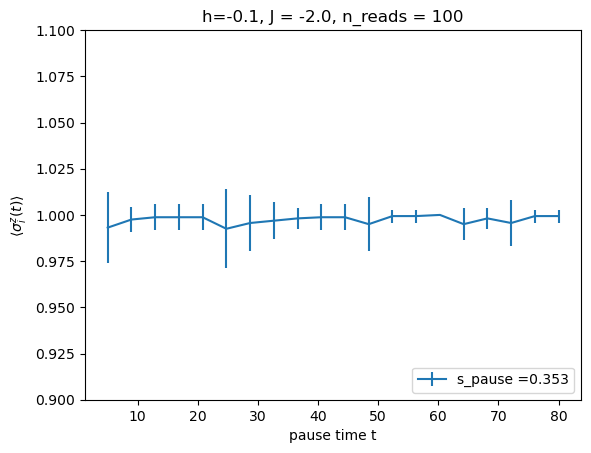

In [72]:

fig = plt.figure()
x = pause_list
y = mag_vals
yerr = mag_errs

plt.errorbar(x, y, yerr=yerr, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.ylabel(r"$\langle \sigma^z_i (t) \rangle$")
plt.xlabel("pause time t")
plt.legend(loc='lower right')
plt.ylim([0.9, 1.1])

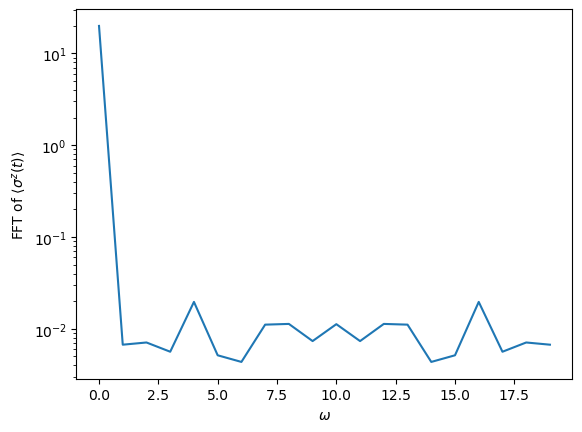

In [85]:
fftvals = np.abs(np.fft.fft(mag_vals))
plt.plot(fftvals)
plt.yscale('log')
plt.ylabel(r"FFT of $\langle  \sigma^z (t)\rangle$")
plt.xlabel(r"$\omega$");